<a href="https://colab.research.google.com/github/bilnazir/stockmarketprediction/blob/transformer/fyp_transformer_amzn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=b3459750e6c1f92487921d5da953ff83e70161bc94db7170b1486e314af00879
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
import yfinance as yf

In [4]:
# Load historical stock data (date, closing price) into a pandas DataFrame
df = yf.download(tickers=['AMZN'], start='2012-01-01', end='2022-06-20')
data = df.dropna()


[*********************100%%**********************]  1 of 1 completed


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2633 entries, 2012-01-03 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2633 non-null   float64
 1   High       2633 non-null   float64
 2   Low        2633 non-null   float64
 3   Close      2633 non-null   float64
 4   Adj Close  2633 non-null   float64
 5   Volume     2633 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 144.0 KB


In [6]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,8.794500,8.974000,8.777500,8.951500,8.951500,102216000
2012-01-04,8.960500,9.025000,8.803500,8.875500,8.875500,84104000
2012-01-05,8.797000,8.912500,8.702500,8.880500,8.880500,76182000
2012-01-06,8.903500,9.232500,8.875000,9.130500,9.130500,140168000
2012-01-09,9.138000,9.218500,8.850000,8.928000,8.928000,101138000
...,...,...,...,...,...,...
2022-06-13,104.190002,106.540001,101.860001,103.669998,103.669998,99277700
2022-06-14,104.190002,104.879997,101.430000,102.309998,102.309998,69728800
2022-06-15,103.860001,109.059998,103.529999,107.669998,107.669998,85011100


In [7]:
data.shape

(2633, 6)

In [8]:
# Adding indicators
import pandas_ta as ta
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close','Date'], axis=1, inplace=True)

<ipython-input-8-8a8148f44cbd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]


In [9]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,11.7780,11.7870,11.6905,11.6995,58.920636,11.385374,10.634717,10.180807,0.121500,1,11.8280
1,11.7065,11.9000,11.6625,11.8280,61.131952,11.427529,10.658346,10.202624,-0.045500,0,11.7190
2,11.7645,11.8225,11.6795,11.7190,58.280677,11.455288,10.679349,10.222708,0.006500,1,11.7030
3,11.6965,11.7995,11.6750,11.7030,57.856280,11.478880,10.699620,10.242315,-0.016500,0,11.6375
4,11.6540,11.7425,11.5715,11.6375,56.065531,11.493986,10.718191,10.260794,0.010500,1,11.6220
5,11.6115,11.7185,11.5500,11.6220,55.628975,11.506178,10.736089,10.278823,-0.076000,0,11.6595
6,11.7355,11.8360,11.6310,11.6595,56.506844,11.520780,10.754374,10.297110,0.258000,1,11.8710
7,11.6130,11.9070,11.6125,11.8710,61.151395,11.554134,10.776485,10.317957,0.191501,1,12.0775
8,11.8860,12.1410,11.8100,12.0775,65.055119,11.603979,10.802248,10.341262,0.028501,1,12.0585
9,12.0300,12.1675,12.0235,12.0585,64.417000,11.647267,10.827124,10.364007,-0.051000,0,12.0175


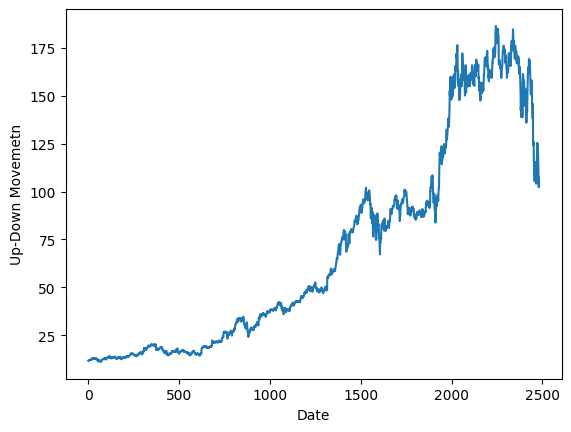

In [10]:
import matplotlib.pyplot as plt
data_set_AC=data_set['Adj Close']
plt.ylabel('Up-Down Movemetn')
plt.xlabel('Date')
plt.plot(data_set_AC)

In [11]:
# Normalize the data
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data)

In [12]:
# Prepare the data for training
X, y = [], []
backcandles = 20
for i in range(backcandles, data_set_scaled.shape[0]):
    X.append(data_set_scaled[i - backcandles:i, :-1])
    y.append(data_set_scaled[i, -1])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Build the Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention mechanism
    attn_output = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed-forward neural network
    ffn_output = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attn_output)
    ffn_output = tf.keras.layers.Dropout(dropout)(ffn_output)
    ffn_output = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ffn_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)

In [14]:
# Build the Transformer model
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
):
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

In [15]:
input_shape = X_train.shape[1:]
head_size = 128
num_heads = 4
ff_dim = 32
num_transformer_blocks = 8
mlp_units = [64, 32]

In [16]:
# Create and compile the Transformer model
model = build_transformer_model(
    input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=0.25,
)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])


In [17]:
# Training the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=128,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 767ms/step - loss: 0.1285 - mean_absolute_error: 0.2595 - val_loss: 0.0218 - val_mean_absolute_error: 0.1201
Epoch 2/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0311 - mean_absolute_error: 0.1256 - val_loss: 0.0233 - val_mean_absolute_error: 0.1253
Epoch 3/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0250 - mean_absolute_error: 0.1151 - val_loss: 0.0181 - val_mean_absolute_error: 0.1103
Epoch 4/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0223 - mean_absolute_error: 0.1069 - val_loss: 0.0118 - val_mean_absolute_error: 0.0866
Epoch 5/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0179 - mean_absolute_error: 0.0950 - val_loss: 0.0079 - val_mean_absolute_error: 0.0707
Epoch 6/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0157 - mean_absolute_error: 0.0924 - val_loss: 0.0079 - val_mean_absolute_error: 0.0736
Epoch 7/128
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126 - mean_absolute_error: 0.0791 -

In [18]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.076303,0.196979,0.021848,0.120076
1,0.030988,0.124954,0.023276,0.125330
2,0.023762,0.110061,0.018056,0.110288
3,0.021394,0.105502,0.011811,0.086635
4,0.017230,0.092773,0.007892,0.070665


<Axes: >

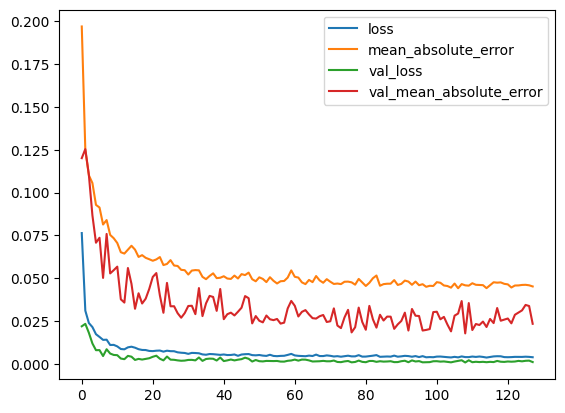

In [19]:
# Training errors with respect to ecochs.
# loss: values of the cost function for training data.
# val_loss: values of the cost function for cross-validation data.
hist.plot()

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 20, 10)         │         22,026 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 10)         │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 20, 10)         │             20 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 20, 32)         │            352 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 32)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 20, 10)         │            330 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 20, 10)         │              0 │ layer_normalization[0… │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 20, 10)         │             20 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 20, 10)         │         22,026 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 20, 10)         │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 20, 10)         │             20 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 20, 32)         │            352 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 20, 32)         │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 20, 10)         │            330 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)          

 Total params: 554,405 (2.11 MB)

 Trainable params: 184,801 (721.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,604 (1.41 MB)

In [21]:
# Make predictions
y_pred = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0233
Mean Squared Error (MSE): 0.0010
Root Mean Squared Error (RMSE): 0.0308
R-squared (R2) score: 0.9895


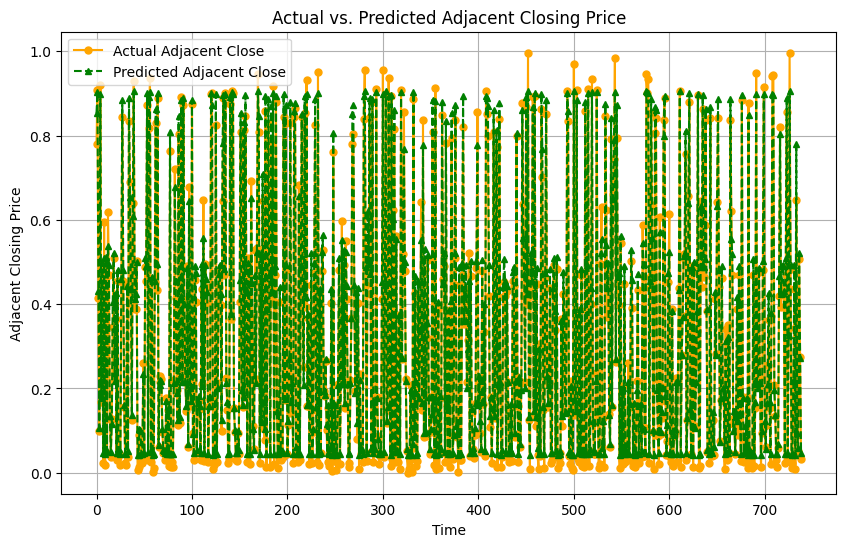

In [23]:
# Plot the actual and predicted adjacent closing prices
# Assuming y_test and y_pred are numpy arrays
y_test = y_test.squeeze()
y_pred = y_pred.squeeze()

plt.figure(figsize=(10, 6))  # Increase figure size for better visibility

# Plot actual values as blue circles
plt.plot(y_test, label='Actual Adjacent Close', color='orange', marker='o', linestyle='-', markersize=5)

# Plot predicted values as red triangles
plt.plot(y_pred, label='Predicted Adjacent Close', color='green', marker='^', linestyle='--', markersize=5)

plt.xlabel('Time')
plt.ylabel('Adjacent Closing Price')
plt.title('Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

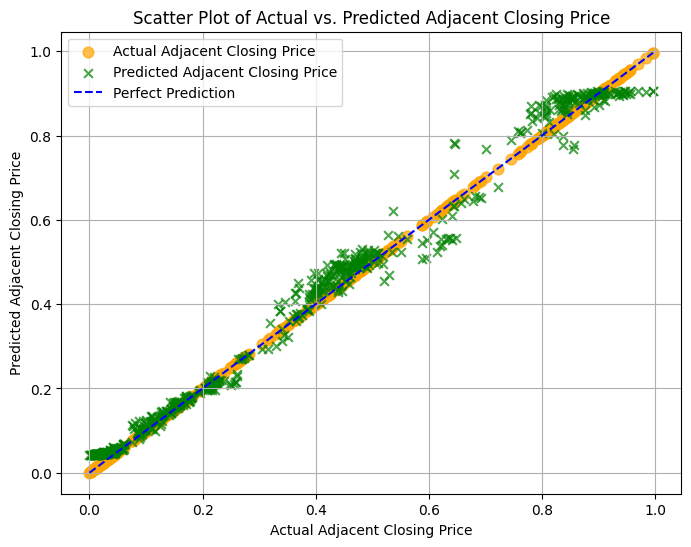

In [24]:
# Scatter plot of actual vs. predicted adjacent closing prices
plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

# Plot actual values as orange circles with larger markers
plt.scatter(y_test, y_test, color='orange', label='Actual Adjacent Closing Price', alpha=0.7, s=60)

# Plot predicted values as black crosses with smaller markers
plt.scatter(y_test, y_pred, color='green', label='Predicted Adjacent Closing Price', alpha=0.7, s=40, marker='x')

# Plot the diagonal line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Adjacent Closing Price')
plt.ylabel('Predicted Adjacent Closing Price')
plt.title('Scatter Plot of Actual vs. Predicted Adjacent Closing Price')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

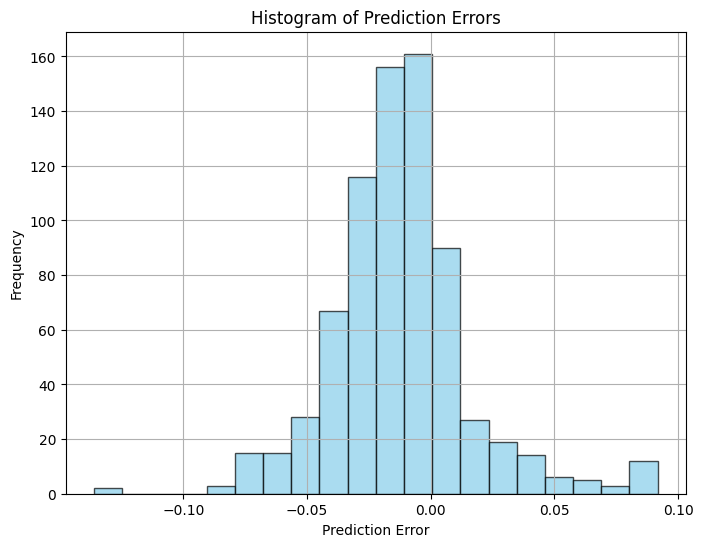

In [25]:
# Histogram of prediction errors
errors = y_test - y_pred

plt.figure(figsize=(8, 6))  # Increase figure size for better visibility

plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

# Add grid lines for better readability
plt.grid(True)

plt.show()
